### Wine Classification System (Wine Dataset)

#### Step 1: Data Preparation

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the wine data
wine_df = pd.read_csv('wine_data.csv')

In [13]:
# Initial EDA
print(wine_df.head())

print(wine_df.info())

print(wine_df.describe())

print(wine_df['target'].value_counts(normalize=True))

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0          

*Initial Data Exploration Notes*

- all features are float data types with no missing values
- the target variable is encoded (0, 1, 2) and also has no missing values
- the target variable is relatively evenly distributed between the 3 values

<Figure size 1500x1000 with 0 Axes>

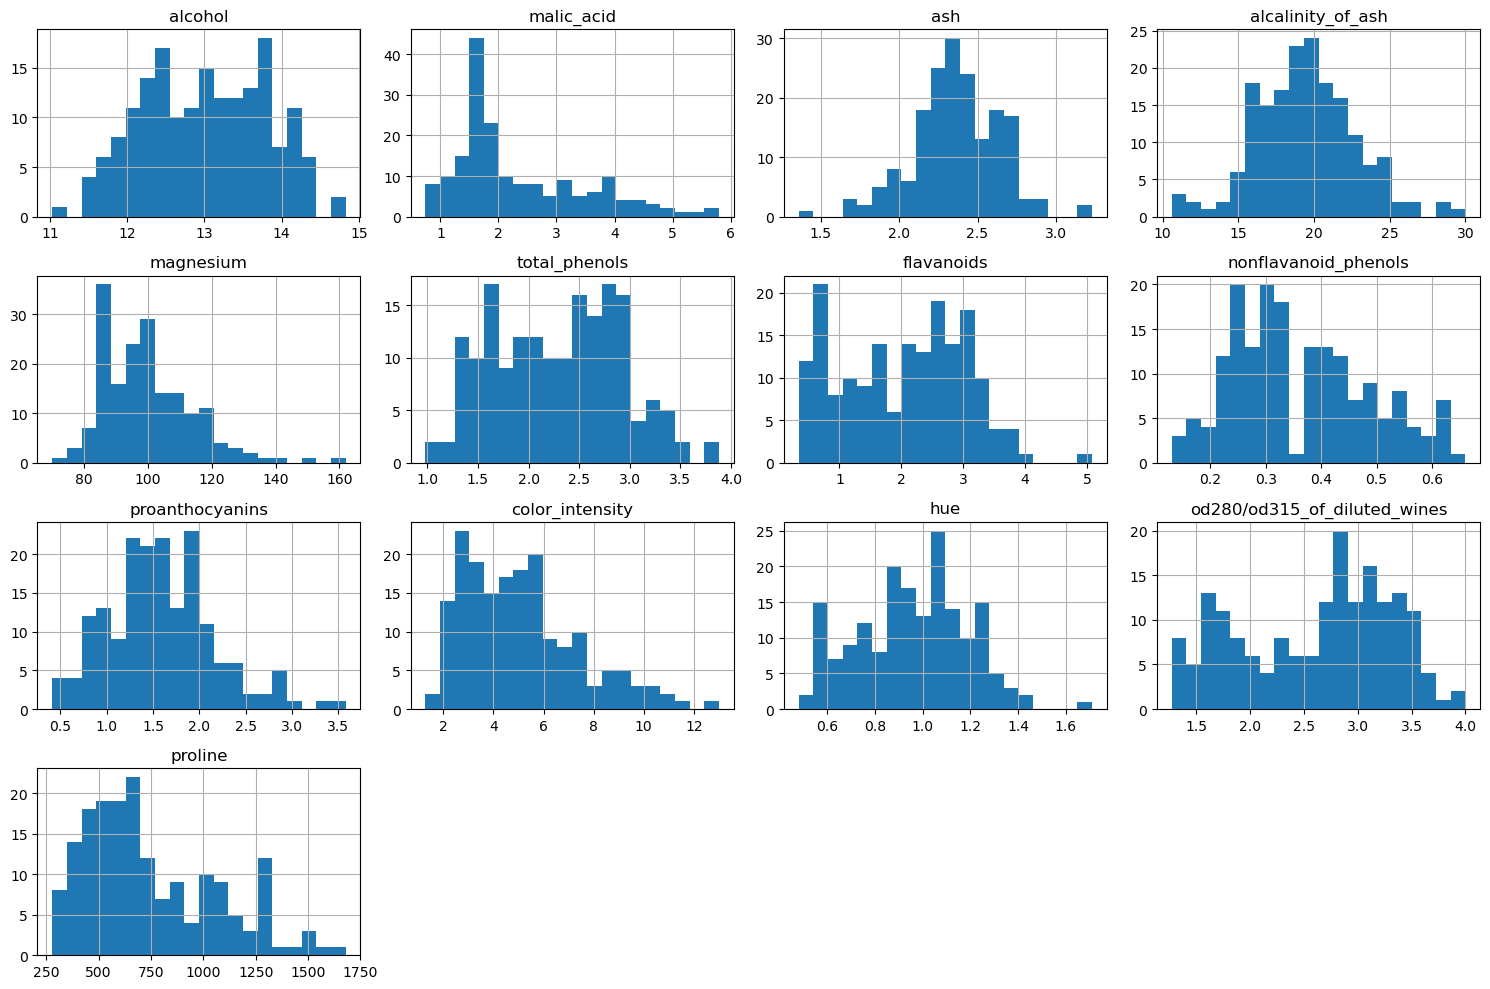

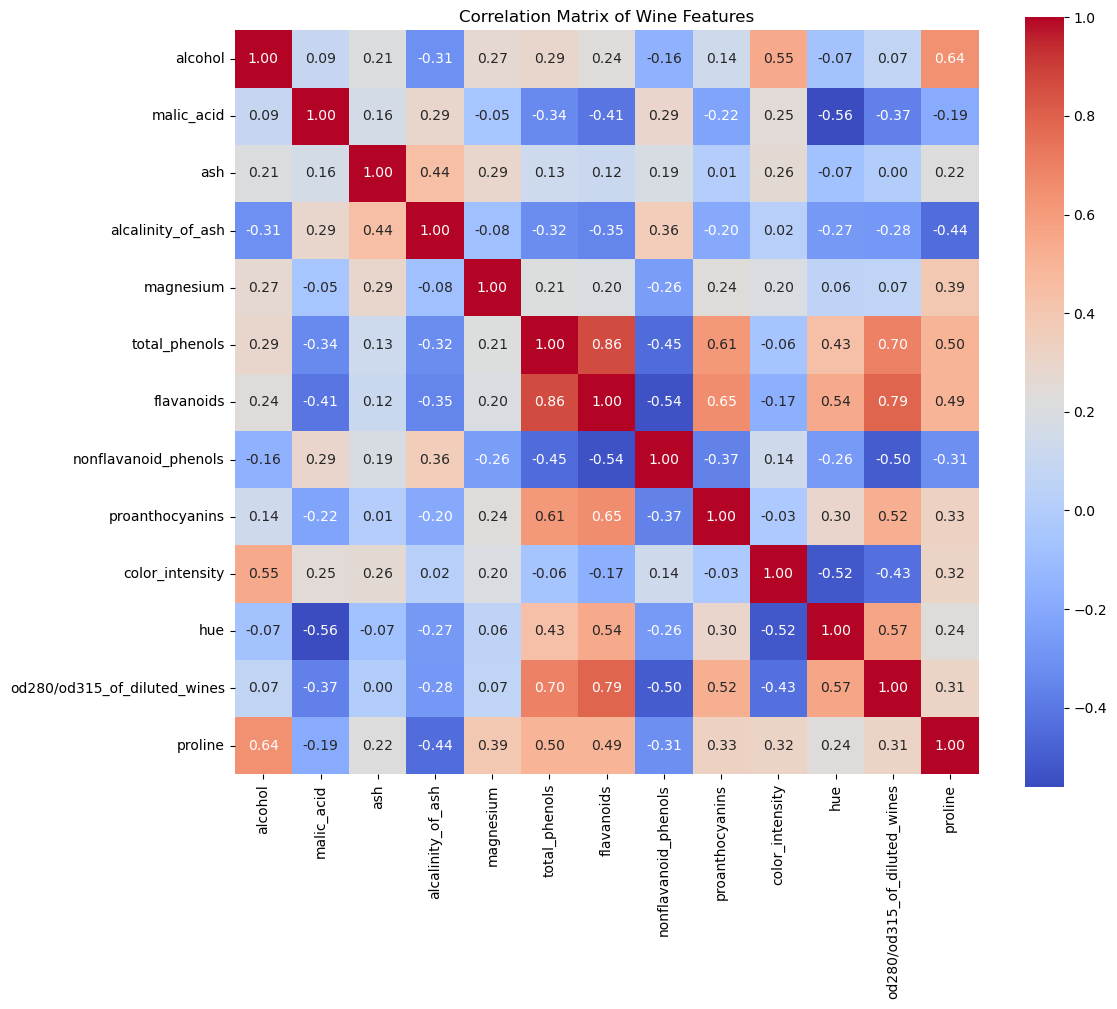

In [15]:
# Exploring feature relationships with feature histograms and a correlation matrix
features = ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 
            'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 
            'od280/od315_of_diluted_wines', 'proline']

plt.figure(figsize=(15, 10))
wine_df[features].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

corr_matrix = X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Wine Features')
plt.show()

*Notes on Data Characteristics*

- measurement scales vary significantly across the features, underscoring the need to standardize
- feature pairs such as total_phenols and flavanoids show strong correlation, suggesting Mahalanobis distance may be the best distance metric

In [18]:
# creating a feature df
X = wine_df.drop('target', axis=1)
y = wine_df['target']

# Splitting the data into training and testing sets (80-20 split, random_state of 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [19]:
# spot checking feature scaling

print("Original first sample:")
print(X_train.iloc[0].values[:5], "...")
print("\nScaled first sample:")
print(X_train_scaled[0][:5], "...")

Original first sample:
[14.34  1.68  2.7  25.   98.  ] ...

Scaled first sample:
[ 1.66529275 -0.60840587  1.21896194  1.60540017 -0.16738426] ...


#### Step 2: Implementing and Optimizing k-Nearest Neighbors

In [22]:
# exploring various distance metrics and evaluating performance with cv scores
metrics = ['euclidean', 'manhattan', 'chebyshev']
k_value = 5

# Dictionary to store results
results = {}

# Loop through list of metrics
for metric in metrics:
        # Create and evaluate model with different metrics and k=5
    knn = KNeighborsClassifier(n_neighbors=k_value, metric=metric)
    # Get cross val scores for model
    cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    # Store the mean of cv scores as value and metric name as key in results dictionary
    results[metric] = cv_scores.mean()

best_metric = max(results, key=results.get)

print(results)

{'euclidean': 0.9509852216748769, 'manhattan': 0.9785714285714286, 'chebyshev': 0.9229064039408866}


Manhattan distance has the best accuracy score at 0.9786. I'll next explore the Mahalanobis distance.

In [24]:
cov = np.cov(X_train_scaled, rowvar=False)
metric_params = {'V': cov}

# k-NN with Mahalanobis distance and k=5
knn_mahalanobis = KNeighborsClassifier(metric='mahalanobis', metric_params=metric_params)

# cross val to evaluate
cv_scores_mahalanobis = cross_val_score(knn_mahalanobis, X_train_scaled, y_train, cv=5, scoring='accuracy')
results['mahalanobis'] = cv_scores_mahalanobis.mean()

print(results)

{'euclidean': 0.9509852216748769, 'manhattan': 0.9785714285714286, 'chebyshev': 0.9229064039408866, 'mahalanobis': 0.8945812807881774}


Mahalanobis distance showed the lowest accuracy so Manhattan remains the best metric. Moving to hyperparameter tuning using Manhattan.

In [29]:
# defining a parameter grid for grid search
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance']
}

# creating the base model
base_model = KNeighborsClassifier(metric='manhattan')

# grid search
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_cv_accuracy = grid_search.best_score_

Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9786


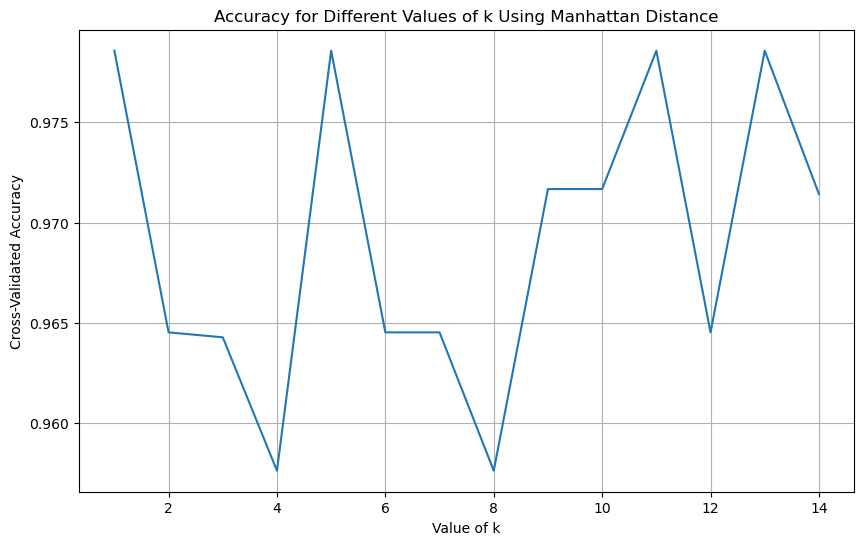

In [30]:
# visualizing accuracy for different k values 

print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_cv_accuracy:.4f}")

k_range = range(1, 15)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    k_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of k')
plt.ylabel('Cross-Validated Accuracy')
plt.title(f'Accuracy for Different Values of k Using Manhattan Distance')
plt.grid(True)
plt.show()

#### Step3: Final Model Fitting and Evaluation

In [ ]:
# fitting the final model
final_model = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='manhattan')
final_model.fit(X_test_scaled, y_test)

# making predictions on the test set
y_pred = final_model.predict(X_test_scaled)

# calculating accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)

# creating a confusion matrix
cm = confusion_matrix(y_test, y_pred)

Test set accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



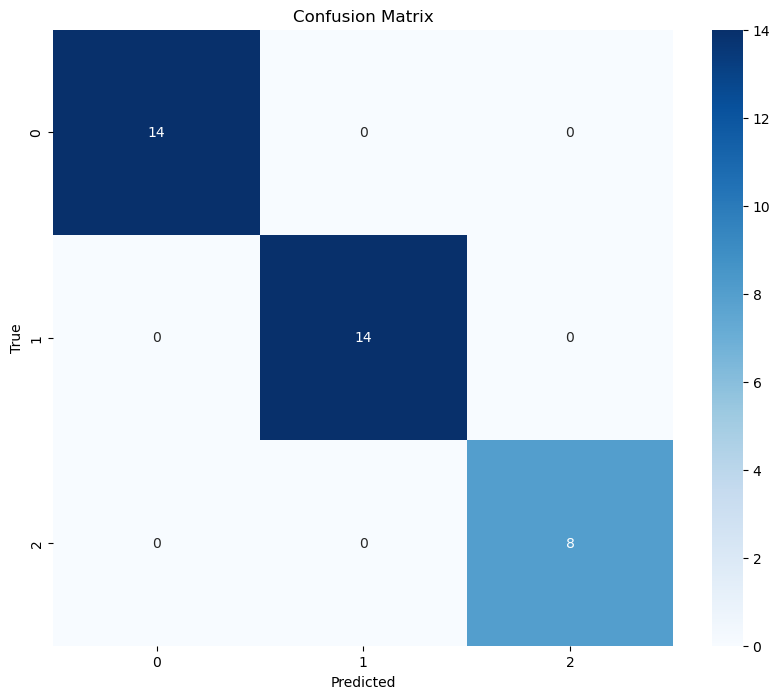

In [32]:
# summary of final model outcomes
print(f"Test set accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Summary of Model Performance and Other Notes

The final version of the k-Nearest Neighbors model for the wine classification system had the following parameters and attributes:

- Distance metric: Manhattan
- Number of neighbors (k): 1
- Neighbor weighting: uniform

The final model performed well in its evaluation: it correctly classified all 36 wines that were in the test dataset. 

More broadly, the model brings us some interesting insights:

- The optimal k value (number of neighbors) of 1 suggests that for wine, similarity to one other type of wine gives a strong indication that the new wine can be classified the same as the reference wine.
- Although multiple pairs of the wine characteristics are correlated, this did not ultimately create complexity in building and optimizing the model.

### Agricultural Feed Recommendation Engine (Chickwts Dataset)

### Regional Crime Pattern Analysis (USArrests Dataset)